In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/' 
  %ls
except:
  pass

from IPython.display import clear_output

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive
'My Drive'/


In [ ]:
### Modify the path to your learning folder ###

%cd 'My Drive/PIE/gym-duckietown/learning'

[Errno 2] No such file or directory: 'My Drive/PIE/gym-duckietown/learning'
/content


In [ ]:
!apt install python-opengl -y
!apt install x11-utils
!apt install xvfb -y 
!pip install pyvirtualdisplay

clear_output()

from pyvirtualdisplay import Display
import os

display = Display(visible=0, size=(640, 480))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
!pip install pyglet opencv-python dataclasses pygeometry
clear_output()

In [ ]:
import ast
import argparse
import logging

import numpy as np
import random
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors

In [ ]:
# Duckietown Specific
from reinforcement.pytorch.ddpg import DDPG
from reinforcement.pytorch.utils import seed, evaluate_policy, ReplayBuffer

from utils.env import launch_env
from utils.wrappers import NormalizeWrapper, ImgWrapper, \
    DtRewardWrapper, ActionWrapper, ResizeWrapper

ModuleNotFoundError: ignored

In [ ]:
## ddpg hyperparameters
expl_noise =0.2
batch_size =64
discount =0.8
tau =0.005
policy_noise =0.2
noise_clip =0.5
policy_freq =2
replay_buffer_max_size =10000

## environment hyperparamters
random_seed = 5412
env_timesteps = 500
eval_freq =2500
max_timesteps =1e5
start_timesteps =1500

## training
save_models = True
load_model= False
model_dir ='reinforcement/pytorch/models/'
model_filename = 'ddpg_14_01'

## plot
plt.style.use('dark_background')
ratio = 0
cmap = plt.cm.get_cmap('magma')
threshold = env_timesteps * ratio
cmaplist = [cmap(i) for i in range(cmap.N)]
for ii in range(int(threshold)):
    cmaplist[ii] = (0.0,0.0,0.0,0.0)
for ii in range(int(threshold),len(cmaplist)):
    cmaplist[ii] = cmap( (ii - threshold) / (len(cmaplist) -  threshold))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

In [ ]:
def train_agent(max_timesteps,env_timesteps,batch_size,discount,tau,eval_freq,replay_buffer_max_size,expl_noise,model_dir,save_models=True,load_model=True):   
        
    # Launch the env with our helper function
    env = launch_env()
    clear_output()
    print("Initialized environment")

    # Wrappers
    env = ResizeWrapper(env)
    env = NormalizeWrapper(env)
    env = ImgWrapper(env) # to make the images from 160x120x3 into 3x160x120
    env = ActionWrapper(env)
    env = DtRewardWrapper(env)
    clear_output()
    print("Initialized Wrappers")
    
    # Set seeds
    random.seed(random_seed)

    state_dim = env.observation_space.shape
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    # Initialize policy
    policy = DDPG(state_dim, action_dim, max_action, net_type="cnn")
    replay_buffer = ReplayBuffer(replay_buffer_max_size)
    print("Initialized DDPG")

    if load_model:
        policy.load(filename=model_filename, directory=model_dir)
        print('Model loaded')
    
    # Evaluate untrained policy
    evaluations= [evaluate_policy(env, policy, eval_episodes=10, max_timesteps=env_timesteps)]
   
    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    done = True
    episode_reward = None
    env_counter = 0
    reward = 0
    episode_timesteps = 0

    episode_lengths = []
    episode_average_rewards = []
    to_print = []
    dists = []
    dot_dirs = []
    episode_dists = []
    episode_dot_dirs = []

    now = datetime.now() # current date and time
    month = now.strftime("%m")
    day = now.strftime("%d")

    start_time = time.time()

    clear_output()
    
    print("Starting training")

    while total_timesteps < max_timesteps:
            
        if done:
            if total_timesteps != 0:
                
                ## print(("\rTotal T: %d Episode Num: %d - - Episode T: %d Reward per timestep: %f") % (total_timesteps, episode_num-1, episode_timesteps, episode_reward/episode_timesteps))
                
                episode_average_rewards.append(episode_reward/episode_timesteps)
                episode_lengths.append(episode_timesteps)
                
                to_print.append(episode_reward)
                dists.append(np.mean(episode_dists))
                dot_dirs.append(np.mean(episode_dot_dirs))

                policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau)

                # Evaluate episode
                if timesteps_since_eval >= eval_freq:

                    timesteps_since_eval %= eval_freq
                    evaluations.append(evaluate_policy(env, policy,eval_episodes=10,max_timesteps=env_timesteps))

                    clear_output()

                    elapsed = time.time() - start_time
                    print("\rRewards at time {}: {}".format(total_timesteps, evaluations[-1],elapsed))                   
                    
                    t = np.arange(1,len(to_print)+1)
                    threshold = env_timesteps * ratio
                    colors = ['black'] * len(t)
                    for ii in range(len(t)):
                        if episode_lengths[ii] >= threshold:
                            colors[ii] = cmap( 0.75 * (episode_lengths[ii] - threshold) / (env_timesteps - threshold) )

                    fig, axs = plt.subplots(3, 1, figsize=(28, 10))

                    axs[0] = plt.subplot(311)
                    axs[0].set(ylabel='Total Reward per Episode')
                    axs[0].grid(True)
                    im = axs[0].plot(t, to_print,color='white',alpha=0.7,zorder=-1)
                    im = axs[0].scatter(t,to_print,c=episode_lengths,cmap=cmap,s=75,zorder=1)

                    axs[1] = plt.subplot(312,  sharex=axs[0])
                    axs[1] .set(ylabel='Mean Dot-Product')
                    axs[1] .grid()
                    im = axs[1].plot(t, dot_dirs,color='white',alpha=0.7,zorder=-1)
                    im = axs[1].scatter(t,dot_dirs,c=episode_lengths,cmap=cmap,s=75,zorder=1)

                    axs[2] = plt.subplot(313, sharex=axs[0])
                    axs[2].set(xlabel='Episode Number', ylabel='Absolute Mean Distance from Lane')
                    axs[2].grid(True)
                    im = axs[2].plot(t, dists,color='white',alpha=0.7,zorder=-1)
                    im = axs[2].scatter(t,dists,c=episode_lengths,cmap=cmap,s=75,zorder=1)

                    

                    plt.subplots_adjust(left=0.2,bottom=0.1, right=0.8, top=0.9, hspace=0.3)
                    plt.colorbar(im, ax=axs).ax.set_xlabel('Episode length')

                    plt.show(fig)

                    if save_models:
                        policy.save(filename=model_filename, directory=model_dir)
                    np.savez("reinforcement/pytorch/results/rewards_{}_{}_{}.npz".format(day,month,env_timesteps),evaluations)

            # Reset environment
            env_counter += 1
            obs = env.reset()
            done = False
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1

            episode_dists = []
            episode_dot_dirs = []


        # Select action randomly or according to policy
        if total_timesteps < start_timesteps:
            action = env.action_space.sample()
        else:
            action = policy.predict(np.array(obs))
            if expl_noise != 0:
                action = (action + np.random.normal(
                    0,
                    expl_noise,
                    size=env.action_space.shape[0])
                          ).clip(env.action_space.low, env.action_space.high)

        # Perform action
        new_obs, reward, done, _ = env.step(action)

        lp = env.get_lane_pos2(env.cur_pos,env.cur_angle)
        episode_dists.append(np.abs(lp.dist))
        episode_dot_dirs.append(lp.dot_dir)

        if episode_timesteps >= env_timesteps:
            done = True

        done_bool = 0 if episode_timesteps + 1 == env_timesteps else float(done)
        episode_reward += reward

        # Store data in replay buffer
        replay_buffer.add(obs, new_obs, action, reward, done_bool)

        obs = new_obs

        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1
    
    print("Training done, about to save..")
    policy.save(filename=model_filename, directory=model_dir)
    print("Finished saving..should return now!")

    return episode_lengths , episode_average_rewards

Rewards at time 55135: -3948.1867905027952


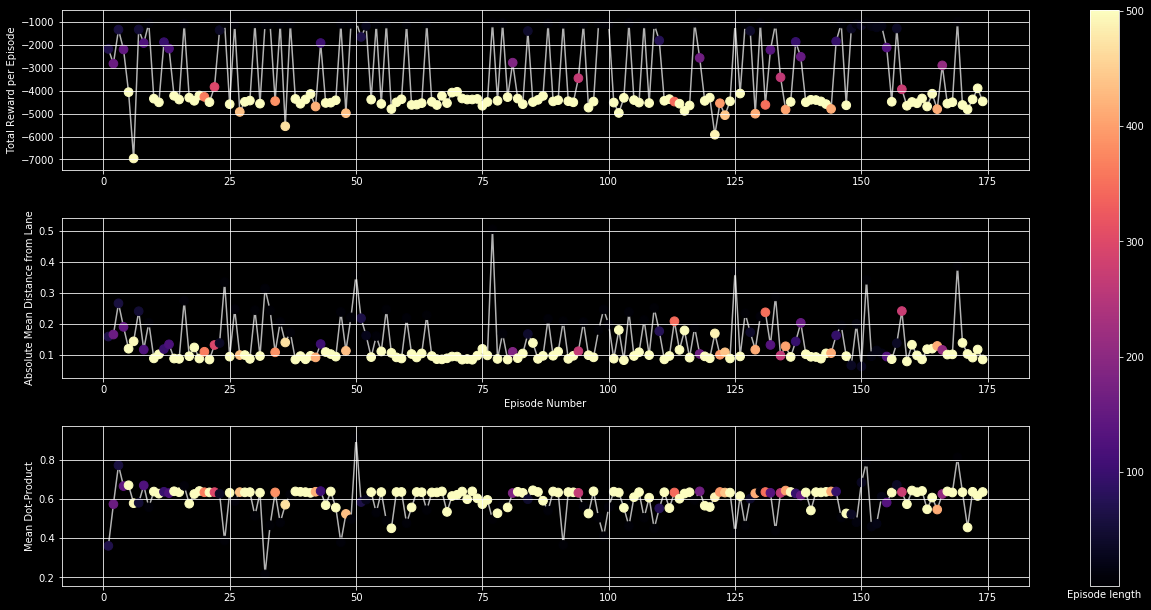

Saving to reinforcement/pytorch/models//ddpg_14_01_[actor|critic].pth
Saved Actor
Saved Critic


In [ ]:
episode_lengths , episode_average_rewards = train_agent(max_timesteps,env_timesteps,batch_size,discount,tau,eval_freq,replay_buffer_max_size,
                                                        expl_noise, model_dir,save_models=save_models,load_model=load_model)
                                                        

In [ ]:
f                                                                                                                                                                                                                                   vb§

In [ ]:
res = np.load("./results/rewards.npz")
res.files

In [ ]:
env = launch_env()
clear_output()
print("Initialized environment")

# Wrappers
env = ResizeWrapper(env)
env = NormalizeWrapper(env)
env = ImgWrapper(env) # to make the images from 160x120x3 into 3x160x120
env = ActionWrapper(env)
# env = DtRewardWrapper(env)
clear_output()
print("Initialized Wrappers")

# Set seeds
random.seed(5412)

state_dim = env.observation_space.shape
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

policy = DDPG(state_dim, action_dim, max_action, net_type="cnn")


In [ ]:
policy.load(filename='ddpg', directory=model_dir)

In [ ]:
max_timesteps = 100

In [ ]:
evaluations

[254.88258521859603]